In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
def draw_spectrogram(snd, title):
    sns.set() # Use seaborn's default style to make attractive graphs
    plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook
    plt.plot(snd.xs(), snd.values.T)
    plt.xlim([snd.xmin, snd.xmax])
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.title(title)
    plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

def save_to_wav(snd, filename):
    if ".wav" not in filename:
        filename = filename + ".wav"
    snd.save(filename, "WAV")

import math
def convert_f0_to_semitone(f0):
    res = []
    for freq in f0:
        if freq != 0:
            res.append(round(12*math.log((freq/440),2)+69))
        else:
            res.append(0)
    return res

import pandas as pd
def extract_ori_pitch_to_csv(file):
    snd = parselmouth.Sound(file)

    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    time = []
    f0 = []

    for i in range(len(pitch_values)):
        # if pitch_values[i]!=0:
        f0.append(pitch_values[i].round(decimals=3))
        time.append(pitch.xs()[i].round(decimals=3))

    file_csv = file.replace(".wav","-parselmouth.csv")

    semitone = convert_f0_to_semitone(f0)

    pd.DataFrame({'time':time, 'semitone':semitone, 'f0':f0}).to_csv(file_csv, index=False)

import parselmouth
def remove_noise_with_spectral_subtraction(filename):
    snd = parselmouth.Sound(filename)

    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    final_unvoiced_length = 0
    final_unvoiced_start_time = 0.0
    final_unvoiced_end_time = 0.0
    found_unvoiced = False
    
    for i in range(len(pitch_values)-1):
        temp_unvoiced_length = 0
        temp_unvoiced_start_time = pitch.xs()[i].round(decimals=3)

        while pitch_values[i] == 0.0 and i < len(pitch_values)-1:
            temp_unvoiced_length += 1
            i += 1
        
        temp_unvoiced_end_time = pitch.xs()[i].round(decimals=3)

        bandwidth = temp_unvoiced_end_time - temp_unvoiced_start_time
        # batas minimal bandwidth praat = 0.0625 (dalam detik)

        if temp_unvoiced_length > final_unvoiced_length:
            if temp_unvoiced_start_time <= 0.1 and bandwidth > 0.5 :
                final_unvoiced_length = temp_unvoiced_length
                final_unvoiced_start_time = temp_unvoiced_start_time
                final_unvoiced_end_time = temp_unvoiced_end_time
                found_unvoiced = True
                break
            elif found_unvoiced == False:
                final_unvoiced_length = temp_unvoiced_length
                final_unvoiced_start_time = temp_unvoiced_start_time
                final_unvoiced_end_time = temp_unvoiced_end_time

    if final_unvoiced_length!=0:
        # snd_unvoiced = snd.extract_part(from_time = final_unvoiced_start_time, to_time = final_unvoiced_end_time, 
        # preserve_times=True)
        
        snd_noise_removed = parselmouth.praat.call(snd, "Remove noise", final_unvoiced_start_time, 
        final_unvoiced_end_time, 0.025, 80.0, 10000.0, 40.0, "Spectral subtraction")

        parselmouth.Vector.scale_peak(snd_noise_removed)

        # return parselmouth object
        return snd_noise_removed
    else:
        print("no unvoiced segment found for", filename)
        return snd

In [2]:
import parselmouth
def remove_noise_with_FSD(filename):
    snd = parselmouth.Sound(filename)

    return snd

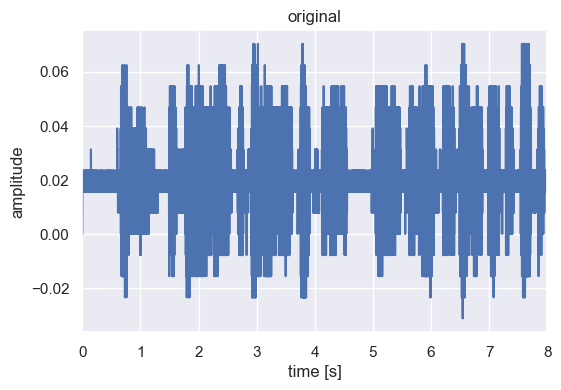

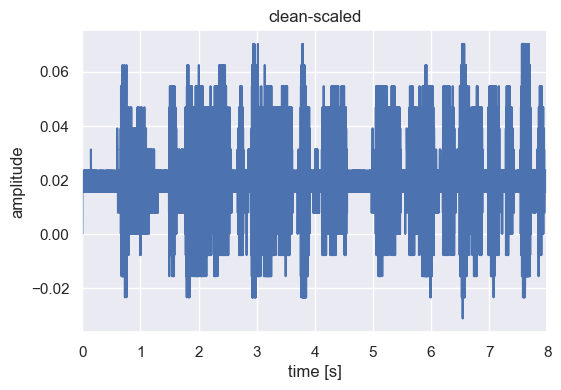

In [3]:
# detect unvoiced with parselmouth
# to be used in spectral subtraction as noisy sample

filename = 'year2003-person00003-00013.wav'
# filename = 'year2003-person00001-00013.wav'

import parselmouth

snd = parselmouth.Sound(filename)
draw_spectrogram(snd,"original")

clean_object = remove_noise_with_FSD(filename)
# save_to_wav(clean_object,filename.replace(".wav","")+"-clean.wav")
draw_spectrogram(clean_object,"clean-scaled")





# clean_object = remove_noise_with_spectral_subtraction(filename)
# save_to_wav(clean_object,filename.replace(".wav","")+"-clean.wav")
# draw_spectrogram(clean_object,"clean-scaled")

In [ ]:
import wave, struct

# framing
file = 'year2003-person00003-00013.wav'
waveFile = wave.open(file, mode='rb')
print(waveFile.getframerate())
print(waveFile.getnchannels())
print(waveFile.getsampwidth())
print(waveFile.getnframes())
f = waveFile.readframes(2)
data = struct.unpack("<h", f)
print(int(data[0]))

In [ ]:
import noisereduce as nr
from scipy.io import wavfile
import IPython
import numpy as np

# load data
rate, data = wavfile.read("year2003-person00003-00013.wav")
# rate, data = wavfile.read("year2003-person00001-00013.wav")
print(len(data))
print(rate)

# # select section of data that is noise
# noisy_part = data[0000:4000].astype(float)
# data = data.astype(float)

# # perform noise reduction
# reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)

# # wavfile.write("example.wav", rate, reduced_noise.astype(np.int8))
# wavfile.write("example.wav", 4000, noisy_part)

In [ ]:
from logmmse import logmmse_from_file
from scipy.io import wavfile
import numpy as np

rate = 8000
out = logmmse_from_file('year2003-person00001-00013.wav')
wavfile.write("year2003-person00001-00013-improved.wav", rate, out.astype(np.int8))